In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

In [3]:
data = pd.read_csv('train.csv')

# 데이터 전처리

In [4]:
# 불필요한 변수 삭제
del data['검사결과코드']
del data['신고번호']
del data['우범여부']


In [5]:
data['신고일자']=pd.to_datetime(data['신고일자'])
data['신고일자']=data['신고일자'].dt.day

In [6]:
for i in data.index:
    val = data.loc[i,'통관지세관부호'] #10, 13, 16, 20, 30, 40
    if val != 10 and val != 13 and val != 16 and val != 16 and val != 20 and val != 30 and val != 40:
        data.loc[i,'통관지세관부호'] = 55


In [7]:
#4077006 이하 통일
for i in data.index:
    val = data.loc[i,'반입보세구역부호']
    if val < 4077007:
        data.loc[i,'반입보세구역부호'] = 4077006

In [8]:
data = data.fillna(0)

In [9]:
# 범주형 변수 지정
categorical_columns = ['신고일자',  '통관지세관부호',
       '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', 
       '수입신고구분코드', '수입거래구분코드', '관세율구분코드', '원산지국가코드',
       '수입종류코드', '징수형태코드', 
       '운송수단유형코드', '반입보세구역부호', 
       'HS10단위부호', '적출국가코드']

# object -> string
for var in categorical_columns:
    data[var] = data[var].astype(str)

In [10]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율', '핵심적발']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)', '과세가격원화금액']:
    data[var] = data[var].apply(lambda x: np.log1p(x))

In [11]:
#data shuffle
data = data.sample(frac=1).reset_index(drop=True)

In [12]:
#data split
data_train = data.iloc[:int(len(data)*0.8), :]
data_test = data.iloc[int(len(data)*0.8):, :]

# Label Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoding_ref = {}
encoder = LabelEncoder()

for var in categorical_columns:
    label_encoding_ref[var] = encoder.fit(data_train[var])
    data_train[var] = label_encoding_ref[var].transform(data_train[var])
       
for var in categorical_columns:
    data_test[var] = label_encoding_ref[var].fit_transform(data_test[var])  
    
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)


<ipython-input-13-b08daf6cf854>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[var] = label_encoding_ref[var].transform(data_train[var])
<ipython-input-13-b08daf6cf854>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[var] = label_encoding_ref[var].fit_transform(data_test[var])


In [14]:
data_train.head(1)

,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,핵심적발
0,17,5,587,1582,1902,0,1,1,23,5,1,8.243808,12.826391,3,41,75,11,13,0,8.0,1


In [15]:
print(data_train.shape, data_test.shape)

(61469, 21) (15368, 21)


In [16]:
# 모델예측 대상인 핵심적발 변수 분리
data_train_y = data_train.pop('핵심적발')
data_test_y = data_test.pop('핵심적발')

In [17]:
# 훈련데이터와 테스트데이터에서 우범건수 비교
from collections import Counter
cnt_train = Counter(data_train_y)
cnt_test = Counter(data_test_y)

print(f"훈련  데이터 비우범건수: {cnt_train[0]}, 훈련  데이터 우범건수: {cnt_train[1]}, 훈련  데이터 핵심건수: {cnt_train[2]}")
print(f"테스트데이터 비우범건수: {cnt_test[0]}, 테스트데이터 우범건수: {cnt_test[1]}, 테스트  데이터 핵심건수: {cnt_test[2]}")


훈련  데이터 비우범건수: 47450, 훈련  데이터 우범건수: 6778, 훈련  데이터 핵심건수: 7241
테스트데이터 비우범건수: 11815, 테스트데이터 우범건수: 1745, 테스트  데이터 핵심건수: 1808


# 랜덤포레스트

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=50, max_depth=1)
rf.fit(data_train, data_train_y)

print('training set accuracy:', rf.score(data_train, data_train_y))
print('test set accuracy:', rf.score(data_test, data_test_y))
# pred = rf.predict(data_test)
# acc = accuracy_score(data_test_y, pred)
# print('acc:', acc)

training set accuracy: 0.7719338202996633
test set accuracy: 0.7688053097345132


# XGBoost

In [19]:
# XGBoost 모델 생성
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [20]:
#imbalanced data의 weight 설정

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=data_train_y
)

In [69]:
# 모델 활성화 및 설정
xgb = XGBClassifier(learning_rate=0.1, objective='multi:softmax', num_class=4,
                   n_estimators=100, max_depth=4) 
#, scale_pos_weight=3, colsample_bytree=0.4, subsample = 0.8,

eval_set = [(data_train, data_train_y), (data_test, data_test_y)]
# 모델 훈련 (training/fitting)
xgb.fit(data_train, data_train_y,early_stopping_rounds=10, 
        eval_metric=["merror", "mlogloss"], sample_weight=classes_weights, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.44022	validation_0-mlogloss:1.06846	validation_1-merror:0.44729	validation_1-mlogloss:1.06900
[1]	validation_0-merror:0.38891	validation_0-mlogloss:1.04302	validation_1-merror:0.39836	validation_1-mlogloss:1.04410
[2]	validation_0-merror:0.38808	validation_0-mlogloss:1.02130	validation_1-merror:0.39947	validation_1-mlogloss:1.02286
[3]	validation_0-merror:0.38654	validation_0-mlogloss:1.00274	validation_1-merror:0.39751	validation_1-mlogloss:1.00456
[4]	validation_0-merror:0.38190	validation_0-mlogloss:0.98657	validation_1-merror:0.39218	validation_1-mlogloss:0.98876
[5]	validation_0-merror:0.37970	validation_0-mlogloss:0.97252	validation_1-merror:0.39159	validation_1-mlogloss:0.97571
[6]	validation_0-merror:0.38094	validation_0-mlogloss:0.96024	validation_1-merror:0.39231	validation_1-mlogloss:0.96374
[7]	validation_0-merror:0.37686	validation_0-mlogloss:0.94949	validation_1-merror:0.38821	validation_1-mlogloss:0.95314
[8]	validation_0-merror:0.37472	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb.predict_proba(data_test)
    
print("roc_auc_score: ", roc_auc_score(data_test_y, test_pred, multi_class='ovr'))

------Evaluating xgboost model------
roc_auc_score:  0.7813820424215293


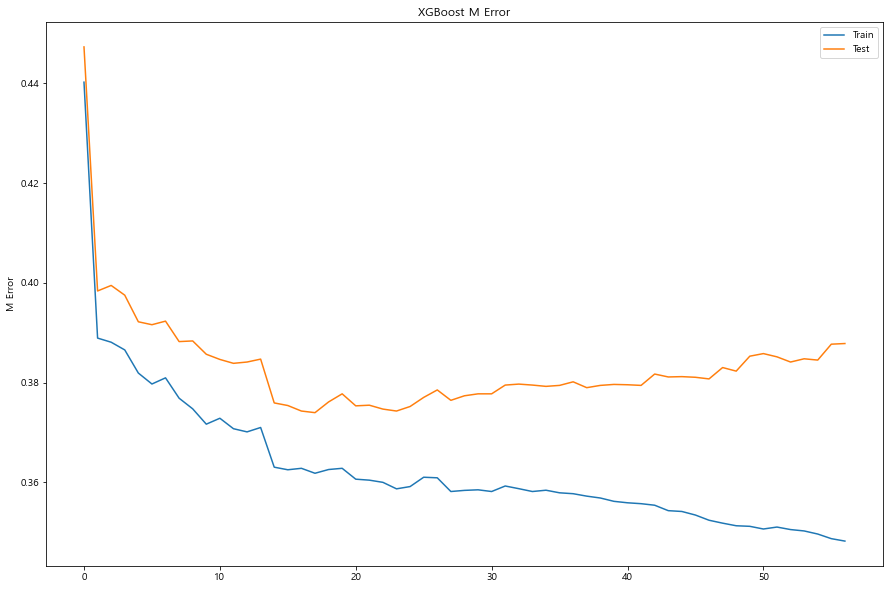

In [63]:
from matplotlib import pyplot
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('M Error')
pyplot.title('XGBoost M Error')
pyplot.show()
# plt.savefig('XGBoost Log Loss.png')

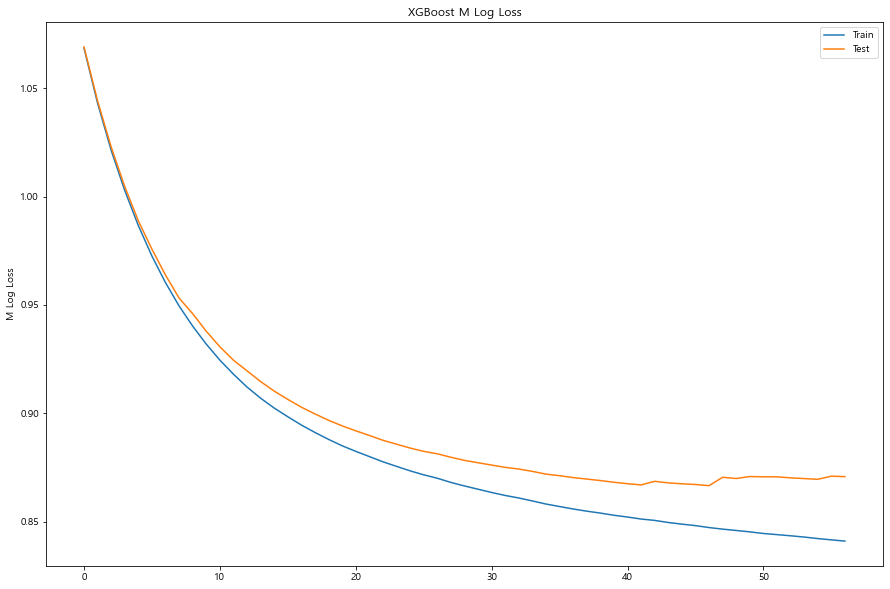

In [64]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('M Log Loss')
pyplot.title('XGBoost M Log Loss')
pyplot.show()
# plt.savefig('XGBoost Log Loss.png')

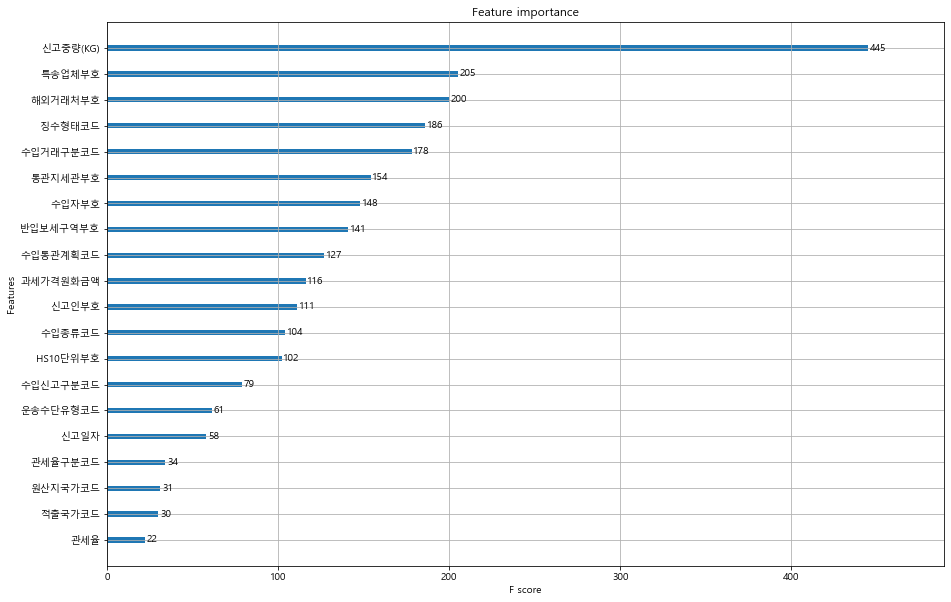

In [65]:
from xgboost import plot_importance
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["figure.figsize"] = (15,10)
plot_importance(xgb, max_num_features=30)
plt.show()

# test

In [51]:
test = pd.read_csv('test.csv')

In [52]:
test.shape

(81058, 21)

In [53]:
test.iloc[23160:23164]

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
23160,83923494.0,2020-12-31,40.0,4TYA6,OEYQJDQ,NaN,NaN,D,B,11.0,21.0,11.0,3793.2,2.673082e+06,10.0,3078022.0,8.525801e+09,VN,VN,CIT,0.0
23161,17890784.0,2020-12-31,30.0,CGMT6,V69LHEI,NaN,PR5UFJ,C,B,11.0,21.0,11.0,5148.8,1.147732e+05,10.0,2006089.0,2.106909e+09,US,US,A,8.0
23162,99164173.0,2020-12-31,16.0,HY5FQ,FUQRKQL,W46PYSV,YGHZ0X,C,B,15.0,21.0,18.0,13906.2,5.470683e+07,40.0,1011065.0,9.018904e+09,JP,JP,A,8.0
23163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
test = test.iloc[:23163]

In [55]:
#train 데이터와 같이 전처리

del test['신고번호']


test['신고일자']=pd.to_datetime(test['신고일자'])
test['신고일자']=test['신고일자'].dt.day

for i in test.index:
    val = test.loc[i,'통관지세관부호'] #10, 13, 16, 20, 30, 40
    if val != 10 and val != 13 and val != 16 and val != 16 and val != 20 and val != 30 and val != 40:
        test.loc[i,'통관지세관부호'] = 55

#4077006 이하 통일
for i in test.index:
    val = test.loc[i,'반입보세구역부호']
    if val < 4077007:
        test.loc[i,'반입보세구역부호'] = 4077006
        
test = test.fillna(0)

# 범주형 변수 지정
categorical_columns = ['신고일자',  '통관지세관부호',
       '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', 
       '수입신고구분코드', '수입거래구분코드', '관세율구분코드', '원산지국가코드',
       '수입종류코드', '징수형태코드', 
       '운송수단유형코드', '반입보세구역부호', 
       'HS10단위부호', '적출국가코드']

# object -> string
for var in categorical_columns:
    test[var] = test[var].astype(str)
    
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율']

# 수치형 변수를 자연로그로 변환
for var in ['신고중량(KG)', '과세가격원화금액']:
    test[var] = test[var].apply(lambda x: np.log1p(x))



In [56]:
#Label Encoding
for var in categorical_columns:
    test[var] = label_encoding_ref[var].fit_transform(test[var])
    
test.reset_index(drop=True, inplace=True)

In [57]:
test.sample(10)

,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율
11193,7,5,377,798,0,0,3,1,0,5,1,9.058587,14.347559,0,40,152,40,39,0,8.0
15686,11,5,691,1474,3724,0,2,1,3,5,1,9.097060,15.317993,0,40,573,80,78,22,0.0
9110,27,5,71,3103,410,0,2,1,0,0,8,8.652039,13.801268,0,44,968,37,36,15,0.0
14299,19,5,691,4890,0,0,1,1,0,5,1,8.876265,11.648971,3,40,933,13,15,0,13.0
10806,4,4,40,4674,2751,0,2,1,0,5,1,8.718991,10.465668,3,40,1265,13,15,10,0.0
11739,9,5,80,1527,554,79,2,2,0,5,8,8.751965,0.000000,3,44,1053,82,80,0,8.0
11631,9,4,609,1809,0,0,1,1,0,5,1,9.584108,14.747621,3,40,89,76,73,0,5.0
15186,0,5,89,1859,0,0,2,1,0,0,1,8.771556,12.713756,0,40,770,80,78,0,0.0
8024,22,6,209,1535,0,0,1,1,3,5,1,9.207266,14.798954,0,40,920,13,15,0,13.0
10819,4,3,231,6264,0,0,0,1,0,5,8,9.217981,13.888182,0,58,170,78,76,0,8.0


# predict

In [70]:
predict = xgb.predict(test)


In [71]:
predict.shape

(23163,)

In [72]:
predict = pd.DataFrame(predict)
counts = predict.value_counts()
counts = pd.DataFrame(counts)
counts = counts.rename(columns = {0:'#ofLabels'})
counts

,#ofLabels
0,
0,13121
1,5349
2,4693


# submission.csv 파일에 저장

In [36]:
submission = pd.read_csv('submission.csv', encoding='CP949')

FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

In [ ]:
result = pd.DataFrame()
result[0] = predict
submission['우범여부'] = result[0]
submission.to_csv('submission_result.csv', index=False, encoding='utf-8-sig')